In [1]:
import random_walker as rw
import utils
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [2]:
H,root,G=rw.make_tree(2.,20,.05,0.,n_max=800)

In [3]:
a,b=utils.block_indices(G,G.target_node)

In [4]:
nodes=list(G.nodes())
alpha=[nodes.index(x) for x in a]
beta=[nodes.index(x) for x in b]
root_ind,target_ind=a.index(G.root),a.index(G.target_node)
alpha_leaves=[a.index(leaf)for leaf in utils.leaves(H) if leaf in a]

/home/k1801311/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/k1801311/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/k1801311/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/k1801311/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.it

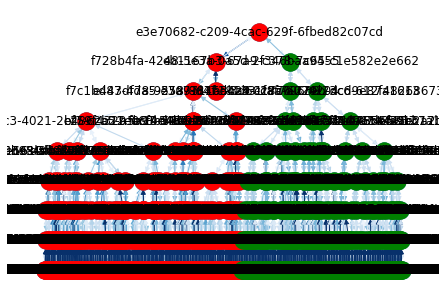

In [5]:
pos=graphviz_layout(H,prog='dot')
(edges,weights) = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, pos, edgelist=edges, edge_color=weights, width=1.0, edge_cmap=plt.cm.Blues)
nx.draw_networkx_nodes(G,pos,nodelist=a,node_color='r')
nx.draw_networkx_nodes(G,pos,nodelist=b,node_color='g')
nx.draw_networkx_labels(G,pos)
plt.show()

In [6]:
G.reset_patterns()
W=nx.to_numpy_matrix(G,nodelist=a+b,weight='weight')
W_alpha=W[:len(a),:len(a)]
W_beta=W[-len(b):,-len(b):]
W_ab=W[:len(alpha),-len(b):]
W_ba=W[-len(b):,:len(a)]
u=np.eye(len(G)-1)-W[1:,1:]
Delta = -W[0,1:]
print(len(G),W_alpha.shape,W_beta.shape,W_ab.shape,W_ba.shape)

1109 (608, 608) (501, 501) (608, 501) (501, 608)


In [7]:
pi=np.concatenate(([[1]],-np.matmul(Delta,np.linalg.inv(u)).T))

In [8]:
pi=pi/np.sum(pi)
print(pi.shape)

(1109, 1)


In [9]:
np.linalg.norm(np.matmul(pi.T, np.eye(len(G))-W ))

2.4087007885427772e-17

In [10]:
X=np.linalg.inv(np.eye(len(a)-1)-W_alpha[1:,1:])
Y=np.linalg.inv( np.eye(len(b))-W_beta )
h=-np.sum(W_alpha[0,:])*X[0,:]
H=np.matmul(np.ones((len(a)-1,1)),h)
delta=np.sum(W_alpha[0,:])*np.sum(np.linalg.matrix_power(X,2)[0,:])
beta=1+np.sum(W_alpha[0,:])*np.sum(X[0,:])
F=X-delta/beta*np.eye(len(a)-1)
y=np.sum(np.matmul(W_ab,Y))

In [11]:
print(beta)

2476.5511935963923


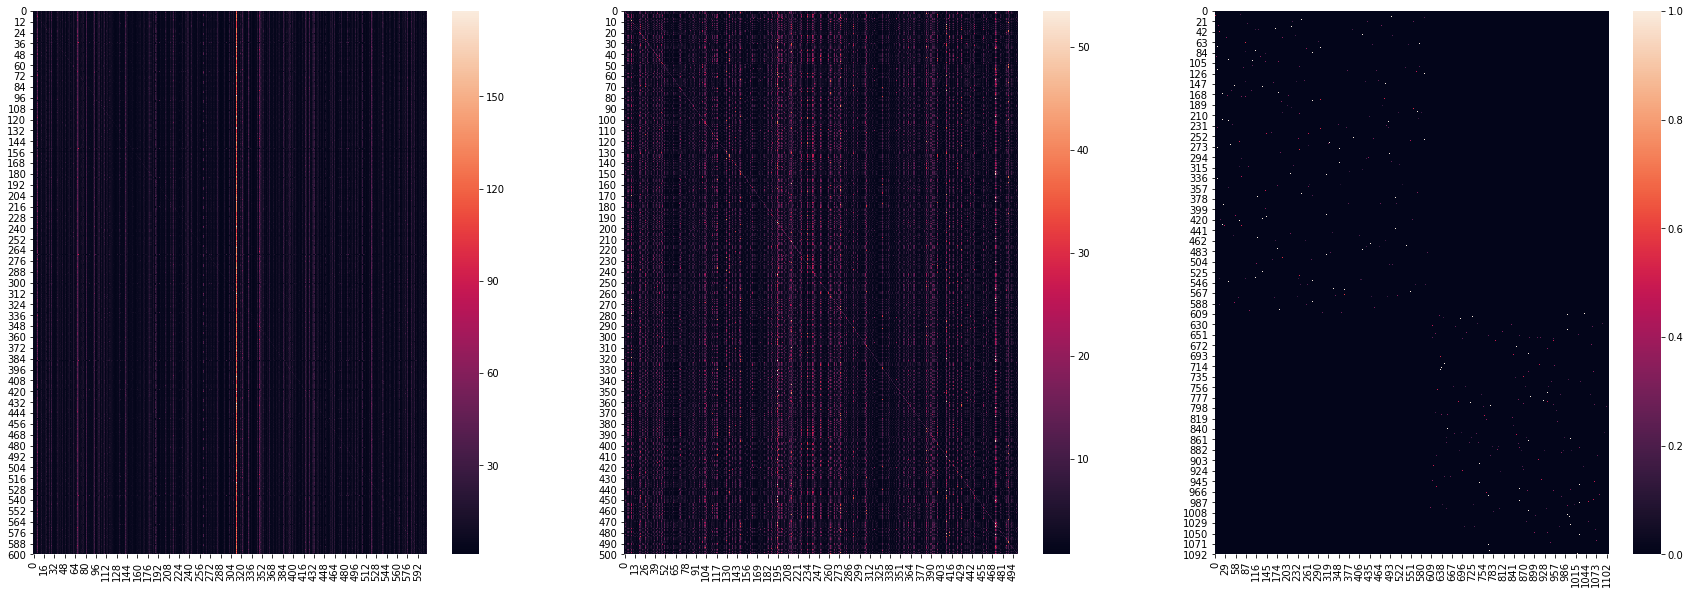

In [12]:
fig,ax=plt.subplots(1,3,figsize=(30,10))
sns.heatmap(X,ax=ax[0])
sns.heatmap(Y,ax=ax[1])
sns.heatmap(W,ax=ax[2])
plt.show()

In [13]:
Q=np.zeros((len(a),len(a))) #Q is the gerneralised group inverse of 1-P_alpha #This is not correct yet.
Q[0,0]=delta/beta**2
Q[0,1:] = -W_alpha[0,1]*1/beta*np.array([ np.linalg.matrix_power(X,2)[0,j]-delta/beta*X[0,j] for j in range(len(X))])#1/beta*np.matmul(h,F)
Q[1:,0] = -1/beta*np.squeeze(np.sum(F, axis=1))
Q[1:,1:]=X+1/delta*(np.matmul(np.matmul(X,H),X) - np.matmul(np.matmul(F,H),F))

In [14]:
P_alpha=W_alpha + np.matmul(np.matmul(W_ab,Y),W_ba)

In [15]:
Qdg = np.diag(np.diag(Q))
gamma_alpha=1/np.sum(pi[:len(a)])
pi_alpha=pi[:len(a)]*gamma_alpha
pi_alpha=np.squeeze(np.array([x for x in pi_alpha]))
MQ = np.matmul(np.eye(len(a))-Q+np.matmul(np.ones((len(a),len(a))),Qdg),np.diag(1/pi_alpha))

In [16]:
print(gamma_alpha)

1.0858639161773704


In [17]:
V_alpha=np.zeros((len(a),len(a)))
FJ=np.matmul(F,np.ones((len(a)-1,len(a)-1)))
V_alpha[0,1:]=delta/beta**2+1/beta*FJ[:,0].T
V_alpha[1:,0]=-delta/beta**2-1/beta*np.squeeze(FJ[:,0])
V_alpha[1:,1:]=-1/beta*(FJ-FJ.T)
V_alpha=y*V_alpha

In [18]:
V_alpha

array([[   0.        ,  274.55733857,  413.39693023, ...,  443.7051881 ,
         423.73044595,  435.1903409 ],
       [-274.55733857,    0.        ,  138.83959166, ...,  169.14784953,
         149.17310739,  160.63300234],
       [-413.39693023, -138.83959166,    0.        , ...,   30.30825787,
          10.33351573,   21.79341068],
       ...,
       [-443.7051881 , -169.14784953,  -30.30825787, ...,    0.        ,
         -19.97474215,   -8.51484719],
       [-423.73044595, -149.17310739,  -10.33351573, ...,   19.97474215,
           0.        ,   11.45989495],
       [-435.1903409 , -160.63300234,  -21.79341068, ...,    8.51484719,
         -11.45989495,    0.        ]])

In [19]:
M=gamma_alpha*MQ+V_alpha
print(M[root_ind,target_ind],np.max(M),V_alpha[root_ind,target_ind],np.max(np.abs(V_alpha/M)),np.min(np.abs(V_alpha/M)))
print(V_alpha/M)

8135.938312707942 11635.722286286344 449.7894200014482 0.9949174711251417 0.0
[[ 0.          0.99491747  0.06426076 ...  0.04521326  0.04139902
   0.12236752]
 [-0.08586392  0.          0.0225493  ...  0.01773475  0.01497825
   0.0489666 ]
 [-0.08586392 -0.08586392  0.         ...  0.0030318   0.00111586
   0.00582776]
 ...
 [-0.08586392 -0.08586392 -0.00434885 ...  0.         -0.00185442
  -0.00528394]
 [-0.08586392 -0.08586392 -0.00185229 ...  0.00197435  0.
   0.00296894]
 [-0.08586392 -0.08586392 -0.00317221 ...  0.00109594 -0.0010738
   0.        ]]


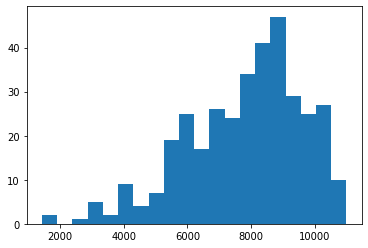

In [20]:
plt.hist([M[root_ind,leaf] for leaf in alpha_leaves],bins=20)
plt.show()

/home/k1801311/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/k1801311/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


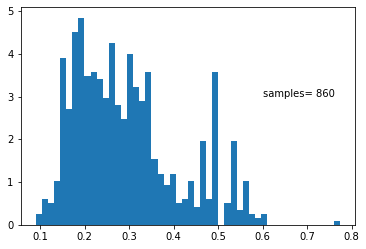

In [21]:
alpha_weights,alpha_bins,_=plt.hist(np.where((W_alpha<1) & (W_alpha>0),W_alpha,np.nan).flat,bins=50,density=True)
plt.text(x=0.6,y=3,s='samples= {}'.format( np.sum(np.where((W_alpha<1) & (W_alpha>0),1,0)) ))
plt.show()

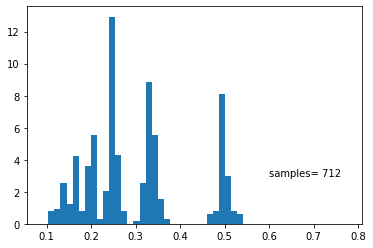

In [22]:
beta_weights,_,_=plt.hist(np.where( (W_beta<1) & (W_beta>0),W_beta,np.nan).flat,bins=alpha_bins,density=True)
plt.text(x=0.6,y=3,s='samples= {}'.format( np.sum(np.where((W_beta<1) & (W_beta>0),1,0)) ))
plt.show()

In [23]:
print(np.mean(W_alpha),np.std(W_alpha))
print(np.mean(W_beta),np.std(W_beta))

0.0016441259996872485 0.03449204335892126
0.0019945592393510927 0.03786884293590047


In [24]:
from scipy.special import kl_div
div_array=kl_div(alpha_weights, beta_weights)
print(np.sum(np.where(div_array<np.inf,div_array,0)))

38.914583551818744


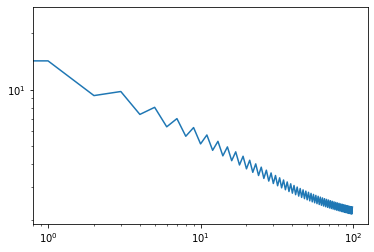

In [47]:
plt.plot([np.linalg.norm(np.linalg.matrix_power(W_alpha,k)) for k in range(0,500,5)])
plt.yscale('log')
plt.xscale('log')